## Reqs

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
from IPython.display import clear_output
from tqdm import tqdm
import gc
import copy

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [6]:
!pip install torchsummary
from torchsummary import summary
clear_output()

## Data

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=1000, shuffle=False)

In [23]:
img, label = next(iter(testloader))

In [25]:
img.shape, label.shape

(torch.Size([1000, 3, 32, 32]), torch.Size([1000]))

## CNN

### archeticture

In [32]:
class ConvNN(nn.Module):
    def __init__(self, num_channels, num_filters, kernel, padding=0, num_classes=10, num_neurons=100, is_dropout=False, debug=False):
        super().__init__()
        self.debug=debug
        self.is_dropout = is_dropout
        self.num_neurons = num_neurons
        self.kernel = kernel
        self.num_filters = num_filters
        self.padding = padding

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=num_filters, kernel_size=kernel, stride=1, padding=padding), # 32 ->
            nn.BatchNorm2d(num_features=num_filters),
            nn.ReLU()
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_filters, out_channels=2*num_filters, kernel_size=kernel, stride=1, padding=padding),
            nn.BatchNorm2d(num_features=2*num_filters),
            nn.ReLU()
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=2*num_filters, out_channels=4*num_filters, kernel_size=kernel, stride=1, padding=padding),
            nn.BatchNorm2d(num_features=4*num_filters),
            nn.ReLU()
        )

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(p=.2)
        self.relu = nn.ReLU()

        self.flat = nn.Flatten()

        self.fc1= nn.LazyLinear(num_neurons)
        self.fc2 = nn.Linear(in_features=num_neurons, out_features=num_neurons)
        self.output = nn.Linear(in_features=num_neurons, out_features=num_classes)

    def forward(self, inp):

        ##conv
        inp = self.block_1(inp)
        inp = self.maxpool(inp)

        inp = self.block_2(inp)
        inp = self.maxpool(inp)

        inp = self.block_3(inp)
        inp = self.maxpool(inp)
        if self.debug: print(f'last layer shape: {inp.shape}')

        if self.is_dropout: inp = self.dropout(inp)

        ##classifier
        inp = self.flat(inp)
        if self.debug: print(f'flattened: {inp.shape}')

        inp = self.fc1(inp)
        inp = self.relu(inp)
        inp = self.fc2(inp)
        inp = self.relu(inp)

        out = self.output(inp)
        if self.debug: print(f'output shape: {out.shape}')
        return out

In [33]:
cnn = ConvNN(num_channels=3, num_filters=32, kernel=3, padding=0, num_classes=10, num_neurons=100, is_dropout=True, debug=False).to(device)
summary(cnn, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
         MaxPool2d-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 64, 13, 13]          18,496
       BatchNorm2d-6           [-1, 64, 13, 13]             128
              ReLU-7           [-1, 64, 13, 13]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 4, 4]          73,856
      BatchNorm2d-10            [-1, 128, 4, 4]             256
             ReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
          Dropout-13            [-1, 128, 2, 2]               0
          Flatten-14                  [

In [34]:
epochs=5
learning_rate=0.001
criterion = nn.CrossEntropyLoss()  # "Good" loss function
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs//2)

### Training

In [13]:
def train_cycle(model, data, optimizer, loss_fn, gradient_clip):
    total_loss=0
    correct=0
    total=0
    model.train()
    for features, labels in tqdm(data):
        features, labels = features.to(device), labels.to(device)

        #forward
        preds = model(features)
        loss = loss_fn(preds, labels)

        #backward
        optimizer.zero_grad()
        loss.backward()

        if gradient_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()

        total_loss += loss.item()
        #accuracy calculation
        outputs = torch.softmax(preds, dim=1) #will softmax the preds so they become logits
        predictions = outputs.argmax(dim=1) #find the index of the highest prob
        correct += (predictions==labels).sum().item()
        total += labels.size(0)

    #calculating losses and accuracies
    avg_batch_loss = total_loss/len(data)
    accuracy = correct/total

    return avg_batch_loss, accuracy

def validation_cycle(model, data, loss_fn):
    total_loss=0
    correct=0
    total=0
    model.eval()
    with torch.inference_mode():
        for features, labels in tqdm(data):
            features, labels = features.to(device), labels.to(device)

            preds = model(features)
            loss = loss_fn(preds, labels)

            total_loss += loss.item()
            #accuracy
            outputs=torch.softmax(preds,dim=1)
            predictions=outputs.argmax(dim=1)
            correct+=(predictions==labels).sum().item()
            total += labels.size(0)
        avg_batch_loss = total_loss/len(data)
        accuracy = correct/total

    return avg_batch_loss, accuracy

def train(model, train_dl, test_dl, optimizer, loss_fn, scheduler, epochs, gradient_clip):

    for epoch in range(epochs):
        torch.cuda.reset_peak_memory_stats()

        ##TRAINING
        train_loss, train_accuracy = train_cycle(model, train_dl, optimizer, loss_fn, gradient_clip)
        scheduler.step
        train_losses.append(train_loss); train_accuracies.append(train_accuracy)
        print()
        print(f'epoch {epoch}/{epochs}')
        print(f'training loss: {train_loss:.4f}, accuracy: {train_accuracy:.2%}')

        ##VALIDATING
        val_loss, val_accuracy = validation_cycle(model, test_dl, loss_fn)
        val_losses.append(val_loss); val_accuracies.append(val_accuracy)
        print(f'validation loss: {val_loss:.4f}, accuracy: {val_accuracy:.2%}')

In [103]:
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]
train(cnn, trainloader, testloader, optimizer, criterion, scheduler, epochs, gradient_clip=None)

100%|██████████| 782/782 [00:15<00:00, 49.78it/s]



epoch 0/10
training loss: 0.4704, accuracy: 83.29%


100%|██████████| 10/10 [00:01<00:00,  5.23it/s]


validation loss: 0.6817, accuracy: 77.65%


100%|██████████| 782/782 [00:14<00:00, 52.24it/s]



epoch 1/10
training loss: 0.4416, accuracy: 84.44%


100%|██████████| 10/10 [00:01<00:00,  5.20it/s]


validation loss: 0.6883, accuracy: 77.94%


100%|██████████| 782/782 [00:16<00:00, 47.70it/s]



epoch 2/10
training loss: 0.4159, accuracy: 85.33%


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


validation loss: 0.6627, accuracy: 78.26%


100%|██████████| 782/782 [00:15<00:00, 51.62it/s]



epoch 3/10
training loss: 0.3980, accuracy: 86.13%


100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


validation loss: 0.6836, accuracy: 78.18%


100%|██████████| 782/782 [00:15<00:00, 52.10it/s]



epoch 4/10
training loss: 0.3721, accuracy: 86.74%


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


validation loss: 0.6960, accuracy: 78.14%


100%|██████████| 782/782 [00:15<00:00, 51.59it/s]



epoch 5/10
training loss: 0.3569, accuracy: 87.38%


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


validation loss: 0.6900, accuracy: 77.33%


100%|██████████| 782/782 [00:15<00:00, 51.98it/s]



epoch 6/10
training loss: 0.3331, accuracy: 88.12%


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


validation loss: 0.7387, accuracy: 77.58%


100%|██████████| 782/782 [00:15<00:00, 49.62it/s]



epoch 7/10
training loss: 0.3263, accuracy: 88.58%


100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


validation loss: 0.6961, accuracy: 78.73%


100%|██████████| 782/782 [00:15<00:00, 51.49it/s]



epoch 8/10
training loss: 0.3092, accuracy: 89.17%


100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


validation loss: 0.6989, accuracy: 79.12%


100%|██████████| 782/782 [00:15<00:00, 49.45it/s]



epoch 9/10
training loss: 0.2945, accuracy: 89.40%


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]

validation loss: 0.7029, accuracy: 78.93%


In [ ]:
#@title if newly initialized
cnn_train_losses = copy.deepcopy(train_losses)
cnn_val_losses = copy.deepcopy(val_losses)
cnn_train_accuracies = copy.deepcopy(train_accuracies)
cnn_val_accuracies = copy.deepcopy(val_accuracies)

In [104]:
#@title extend
cnn_train_losses.extend(train_losses)
cnn_val_losses.extend(val_losses)
cnn_train_accuracies.extend(train_accuracies)
cnn_val_accuracies.extend(val_accuracies)

10 epochs

In [105]:
len(cnn_train_losses)

20

## ViT

### archeticture

In [43]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, emb_size=128, img_size=32):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, emb_size))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x)  # [B, emb_size, H', W']
        x = x.flatten(2).transpose(1, 2)  # [B, N, emb_size]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # [B, N+1, emb_size]
        x = x + self.pos_embed
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, emb_size=128, num_heads=4, mlp_dim=256, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_size)
        self.mha = nn.MultiheadAttention(emb_size, num_heads, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(emb_size)
        self.ffn = nn.Sequential(
            nn.Linear(emb_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.mha(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        x = x + self.ffn(self.ln2(x))
        return x

class SimpleViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, emb_size=128, depth=6, num_heads=4, mlp_dim=256, num_classes=10):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels=3, patch_size=patch_size, emb_size=emb_size, img_size=img_size)
        self.encoder = nn.Sequential(*[
            TransformerEncoder(emb_size, num_heads, mlp_dim) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(emb_size)
        self.head = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x[:, 0])
        return self.head(x)

In [54]:
ViT = SimpleViT(img_size=32, patch_size=4, emb_size=128, depth=6, num_heads=2, mlp_dim=64, num_classes=10).to(device)
summary(ViT, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 8, 8]           6,272
    PatchEmbedding-2              [-1, 65, 128]               0
         LayerNorm-3              [-1, 65, 128]             256
         LayerNorm-4              [-1, 65, 128]             256
         LayerNorm-5              [-1, 65, 128]             256
MultiheadAttention-6  [[-1, 65, 128], [-1, 65, 65]]               0
         LayerNorm-7              [-1, 65, 128]             256
            Linear-8               [-1, 65, 64]           8,256
              GELU-9               [-1, 65, 64]               0
          Dropout-10               [-1, 65, 64]               0
           Linear-11              [-1, 65, 128]           8,320
          Dropout-12              [-1, 65, 128]               0
TransformerEncoder-13              [-1, 65, 128]               0
        LayerNorm-14              

In [99]:
epochs=10
learning_rate=0.001
vitcriterion = nn.CrossEntropyLoss()  # "Good" loss function
vitoptimizer = optim.Adam(ViT.parameters(), lr=learning_rate)
vitscheduler = torch.optim.lr_scheduler.CosineAnnealingLR(vitoptimizer, T_max=epochs//2)

### Training

In [100]:
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]
train(ViT, trainloader, testloader, vitoptimizer, vitcriterion, vitscheduler, epochs, gradient_clip=None)

100%|██████████| 782/782 [00:26<00:00, 29.29it/s]



epoch 0/10
training loss: 0.9668, accuracy: 65.28%


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


validation loss: 1.0655, accuracy: 62.25%


100%|██████████| 782/782 [00:26<00:00, 29.41it/s]



epoch 1/10
training loss: 0.9394, accuracy: 66.37%


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


validation loss: 1.0700, accuracy: 61.85%


100%|██████████| 782/782 [00:28<00:00, 27.93it/s]



epoch 2/10
training loss: 0.9099, accuracy: 67.27%


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


validation loss: 1.0858, accuracy: 61.33%


100%|██████████| 782/782 [00:27<00:00, 28.16it/s]



epoch 3/10
training loss: 0.8778, accuracy: 68.41%


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


validation loss: 1.0666, accuracy: 62.72%


100%|██████████| 782/782 [00:27<00:00, 28.82it/s]



epoch 4/10
training loss: 0.8583, accuracy: 69.10%


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


validation loss: 1.0924, accuracy: 62.53%


100%|██████████| 782/782 [00:26<00:00, 29.57it/s]



epoch 5/10
training loss: 0.8294, accuracy: 70.43%


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


validation loss: 1.0921, accuracy: 62.67%


100%|██████████| 782/782 [00:27<00:00, 28.63it/s]



epoch 6/10
training loss: 0.8099, accuracy: 70.89%


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


validation loss: 1.0576, accuracy: 63.79%


100%|██████████| 782/782 [00:26<00:00, 29.21it/s]



epoch 7/10
training loss: 0.7839, accuracy: 71.87%


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


validation loss: 1.0823, accuracy: 63.11%


100%|██████████| 782/782 [00:26<00:00, 29.36it/s]



epoch 8/10
training loss: 0.7588, accuracy: 72.88%


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


validation loss: 1.0517, accuracy: 63.83%


100%|██████████| 782/782 [00:26<00:00, 29.73it/s]



epoch 9/10
training loss: 0.7354, accuracy: 73.42%


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

validation loss: 1.0186, accuracy: 64.99%


In [60]:
#@title if newly initialized
vit_train_losses = copy.deepcopy(train_losses)
vit_val_losses = copy.deepcopy(val_losses)
vit_train_accuracies = copy.deepcopy(train_accuracies)
vit_val_accuracies = copy.deepcopy(val_accuracies)

In [101]:
#@title extend
vit_train_losses.extend(train_losses)
vit_val_losses.extend(val_losses)
vit_train_accuracies.extend(train_accuracies)
vit_val_accuracies.extend(val_accuracies)

In [96]:
vit_val_accuracies

[0.4366,
 0.5014,
 0.5278,
 0.5403,
 0.5632,
 0.5811,
 0.5889,
 0.5862,
 0.6013,
 0.5992]

In [102]:
len(vit_val_accuracies)

20

## Reports

In [52]:
#@title function def
def plot_learning_curve(
    cnn_train_losses, cnn_val_losses,
    vit_train_losses, vit_val_losses,
    cnn_train_accuracies=None, cnn_val_accuracies=None,
    vit_train_accuracies=None, vit_val_accuracies=None
):
    epochs = range(1, len(cnn_train_losses) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, cnn_train_losses, label='CNN Training Loss', marker='o')
    plt.plot(epochs, cnn_val_losses, label='CNN Validation Loss', marker='o')
    plt.plot(epochs, vit_train_losses, label='ViT Training Loss', marker='x')
    plt.plot(epochs, vit_val_losses, label='ViT Validation Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    if cnn_train_accuracies is not None and cnn_val_accuracies is not None and \
       vit_train_accuracies is not None and vit_val_accuracies is not None:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, cnn_train_accuracies, label='CNN Training Accuracy', marker='o')
        plt.plot(epochs, cnn_val_accuracies, label='CNN Validation Accuracy', marker='o')
        plt.plot(epochs, vit_train_accuracies, label='ViT Training Accuracy', marker='x')
        plt.plot(epochs, vit_val_accuracies, label='ViT Validation Accuracy', marker='x')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()


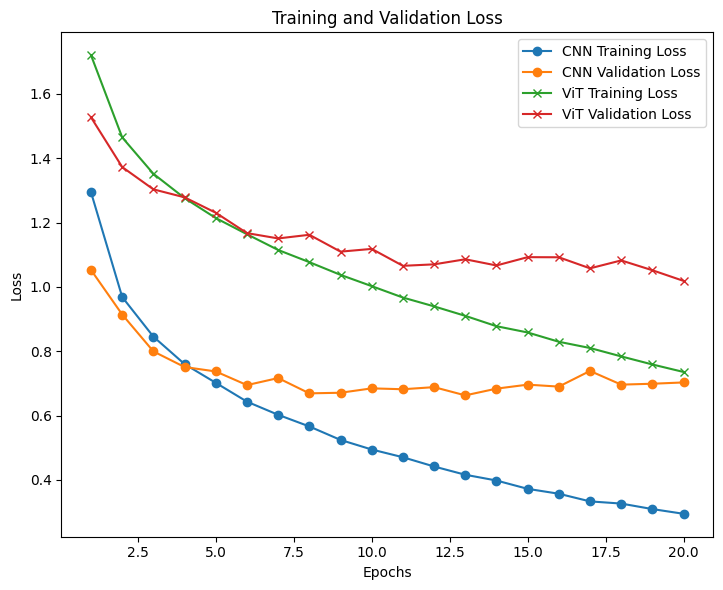

In [106]:
plot_learning_curve(
    cnn_train_losses, cnn_val_losses,
    vit_train_losses, vit_val_losses,
    # cnn_train_accuracies, cnn_val_accuracies,
    # vit_train_accuracies, vit_val_accuracies
)